In [ ]:
## Import all needed libraries

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv2DTranspose, Dropout,
                                     BatchNormalization, LeakyReLU, UpSampling2D,
                                     MaxPool2D, Reshape, Flatten, Input, Embedding,
                                     Concatenate)

from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid

from tqdm.notebook import tqdm

## Load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

## make the data range [-1, 1]
x_train = (x_train / 255.) * 2 - 1
x_test = (x_test / 255.) * 2 - 1

print(x_train.min(), x_train.max())
print(x_test.min(), x_test.max())

## make each image of shape [28, 28, 1] for 2dconv to take effect
x_train, x_test = np.expand_dims(x_train.astype("float32"), axis=-1), np.expand_dims(x_test.astype("float32"), axis=-1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
-1.0 1.0
-1.0 1.0
(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


In [ ]:
## Creating the GAN Architecture

K.clear_session()
# the size of the random vector used in generating new samples
codings_size = 100

## Generator model for normal DCGAN
generator = Sequential([
    Dense(7 * 7 * 128, input_shape=[codings_size]),
    Reshape([7, 7, 128]),
    BatchNormalization(),
    Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")
    # output shape is [28, 28, 1], tanh activation makes the data range from -1 to 1
])


## Creating the discriminator architecture (binary classifier)
discriminator = Sequential([
    Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2), input_shape=[28, 28, 1]),
    Dropout(0.4),
    Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2)),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation="sigmoid")
])

## The GAN model is a sequence of the generator and discriminator
gan = Sequential([generator, discriminator])

## We need to train the discriminator alone on a batch of real and fake images so we will compile while it is trainable
## and train it using the discriminator.fit function
discriminator.compile(optimizer="rmsprop", loss="binary_crossentropy")

## then set trainable to false so that it doesn't train when we call gan.fit
discriminator.trainable = False

## then compile the gan model while discriminator is not trainable
gan.compile(optimizer="rmsprop", loss="binary_crossentropy")

In [ ]:
## Creating a dataset object
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    gen, disc = gan.layers
    for epoch in tqdm(range(n_epochs)):
        ## we will use experience reply so we need to keep track of latest_batch
        latest_batch = None
        for x_batch in tqdm(dataset):
            ## generate random vector
            noise = tf.random.normal(shape=[batch_size, codings_size])
            ## use the vector to generate fake images
            generated_batch = gen(noise)
            ## Make a full batch consisting of real and fake images
            full_batch = tf.concat([generated_batch, x_batch], axis=0)
            ## the real images will have a label of 1 and the fake will have a label of 0
            y1 = tf.constant(tf.concat([tf.zeros([batch_size, 1]), tf.ones([batch_size, 1])], axis=0))

            # to get rid of annoying warnings
            disc.trainable = True

            # experience reply
            if latest_batch is not None:
                disc.train_on_batch(latest_batch[0], latest_batch[1])
                latest_batch = (full_batch, y1)
            
            # train discriminator on the current batch
            disc.train_on_batch(full_batch, y1)

            # create new batch of noise vectors
            noise = tf.random.normal(shape=[batch_size, codings_size])
            # tell the gan to fool the model into thinking that these are real
            y2 = tf.ones([batch_size, 1])

            # avoiding warnings again
            disc.trainable = False

            # train the gan on this batch
            gan.train_on_batch(noise, y2)


train_gan(gan, dataset, batch_size, codings_size)

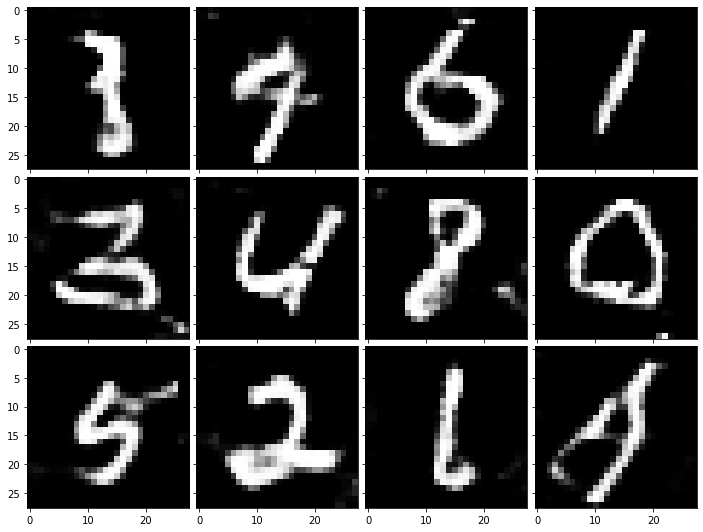

In [ ]:
random_codings = tf.random.normal(shape=[12, codings_size])
images = generator(random_codings).numpy().squeeze()

fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(3, 4),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap="gray")

plt.show()

# Creating a Conditional DCGAN

In [ ]:
## We will use the functional api for this since the sequential api won't suffice.

K.clear_session()
codings_size = 100 # same old
img_disc_input = Input(shape=[28, 28, 1]) # same old

encoding_disc_input = Input(shape=[1]) # now that is new, this is the label, if I want to generate an image of 1 this would be 1
disc_labels_encoded = Embedding(10, 50)(encoding_disc_input) # create a representation of this label of shape 50
disc_labels_encoded = Dense(28*28)(disc_labels_encoded) # run this representation through a dense layer of size 28*28
disc_labels_encoded = Reshape((28, 28, 1))(disc_labels_encoded) # reshape it to the shape of the image

z = Concatenate()([img_disc_input, disc_labels_encoded]) # now stack the label on the image, this is how the model knows which digit you want
z = Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2))(z) # the rest is just same old gan stuff
z = Dropout(0.4)(z)
z = Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2))(z)
z = Dropout(0.4)(z)
z = Flatten()(z)
z = Dense(1, activation="sigmoid")(z)

disc = Model(inputs=[img_disc_input, encoding_disc_input], outputs=[z])
disc.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________________

In [ ]:
gen_img_input = Input(shape=[codings_size]) # same old
gen_img = Dense(7*7*128)(gen_img_input) # same old
gen_img = Reshape((7, 7, 128))(gen_img) # same old

gen_label_input = Input(shape=(1,)) # hey, it's you again! I guess you know what that is.
gen_label_encoded = Embedding(10, 50)(gen_label_input) # again
gen_label_encoded = Dense(7*7)(gen_label_encoded) # and again
gen_label_encoded = Reshape((7, 7, 1))(gen_label_encoded) # and again

x = Concatenate()([gen_img, gen_label_encoded]) # I have finals now, this is why I am not pretty comprehensive, you know.
x = BatchNormalization()(x) # the rest is the same as before
x = Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")(x)

gen = Model(inputs=[gen_img_input, gen_label_input], outputs=[x])


gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6272)         633472      input_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
disc.compile(loss="binary_crossentropy", optimizer="adam")
disc.trainable = False # remember that trick ?

gen_input_one, gen_input_two = gen.input
gen_output = gen.output

disc_output = disc([gen_output, gen_input_two])

gan = Model(inputs=[gen_input_one, gen_input_two], outputs=[disc_output])
gan.compile(loss="binary_crossentropy", optimizer="adam")


In [ ]:
# create batch
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x_train, tf.cast(y_train, tf.int32))).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_conditional_gan(gan, gen, disc, dataset, batch_size, codings_size, n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        latest_batch = None # experience response stuff
        for x_batch, true_labels in tqdm(dataset):
            noise = tf.random.normal(shape=[batch_size, codings_size]) # noise to generate image
            noise_labels = tf.random.uniform(true_labels.shape, dtype="int32", minval=0, maxval=10) # some random a** label from 0 to 9
            generated_batch = gen([noise, noise_labels])

            full_batch = tf.concat([generated_batch, x_batch], axis=0)
            full_labels = tf.concat([noise_labels, true_labels], axis=0)
            y1 = tf.constant(tf.concat([tf.zeros([batch_size, 1]), tf.ones([batch_size, 1])], axis=0))

            disc.trainable = True # warnings

            if latest_batch is not None:
                disc.train_on_batch(latest_batch[0], latest_batch[1])
                latest_batch = ([full_batch, full_labels], y1)
                
            disc.train_on_batch([full_batch, full_labels], y1)

            noise = tf.random.normal(shape=[batch_size, codings_size])
            noisy_labels = tf.random.uniform(true_labels.shape, dtype="int32", minval=0, maxval=10)
            y2 = tf.ones([batch_size, 1])
            disc.trainable = False # warnings

            gan.train_on_batch([noise, noisy_labels], y2)

train_conditional_gan(gan, gen, disc, dataset, batch_size=batch_size, codings_size=codings_size, n_epochs=50)

In [ ]:
def plot_generated_number(n):
    random_codings = tf.random.normal(shape=[12, codings_size])
    random_labels = tf.random.uniform((12, 1), dtype="int32", minval=n, maxval=n+1)
    images = gen([random_codings, random_labels]).numpy().squeeze()

    fig = plt.figure(figsize=(12, 12))
    grid = ImageGrid(
        fig, 111,  # similar to subplot(111)
        nrows_ncols=(3, 4),  # creates 2x2 grid of axes
        axes_pad=0.5,  # pad between axes in inch.
    )

    for ax, im, label in zip(grid, images, random_labels):
        # Iterating over the grid returns the Axes.
        ax.set_title(int(label))
        ax.imshow(im, cmap="gray")

    plt.show()

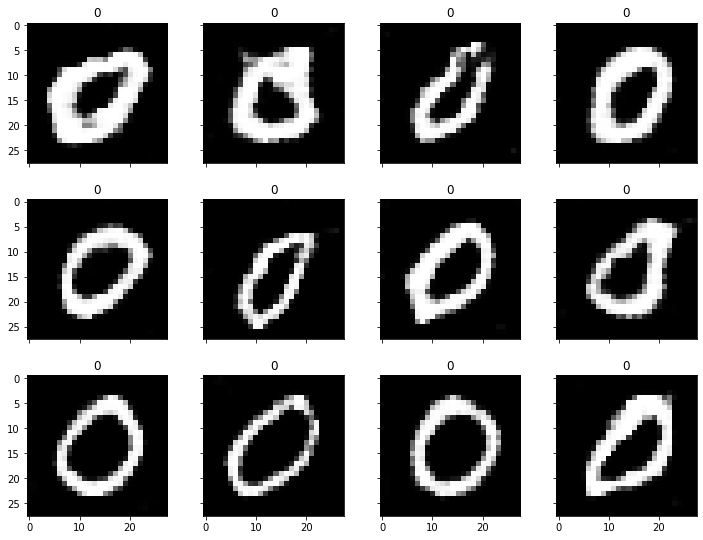

In [ ]:
plot_generated_number(0)

# YAAAAAAIIIIIII !!

In [ ]:
# save the model
gen.save("generator")

INFO:tensorflow:Assets written to: generator/assets


In [ ]:
# zip the model
!tar -czvf gen.tar.gz generator/

generator/
generator/variables/
generator/variables/variables.data-00000-of-00001
generator/variables/variables.index
generator/saved_model.pb
generator/assets/


In [ ]:
# download the model